# Environment setup and libray inclusion

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab/AN2DL/Homework2

# Installing Keras-CV
!pip install -q --upgrade keras-cv albumentations

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab/AN2DL/Homework2


In [ ]:
# Inclusing libraries
from google.colab                           import runtime
from keras_cv.layers                        import AugMix, RandAugment, \
                                                    RandomHue, RandomSaturation
from matplotlib.colors                      import ListedColormap
from tensorflow                             import keras as tfk
from tensorflow.keras                       import layers as tfkl
from tensorflow.keras.applications          import ConvNeXtBase
from tensorflow.keras.models                import Model, load_model
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical, Sequence
from sklearn.metrics                        import accuracy_score, precision_score,\
                                                    recall_score, f1_score,\
                                                    confusion_matrix
from sklearn.model_selection                import train_test_split
from sklearn.utils                          import class_weight

import albumentations                       as A
import matplotlib.pyplot                    as plt
import numpy                                as np
import os, time
import pandas                               as pd
import seaborn                              as sns
import tensorflow                           as tf

Setting seed for our execution environment.

In [ ]:
seed: int = 42
np.random.seed(seed)
tf.random.set_seed(seed)

We define a series of useful functions which will be called throught the notebook.

In [ ]:
def displayImage(image, title="") -> None:
    """
    Function in charge of displaying an image

    -------
    image: image to be displayed
    title: title of the image
    """

    plt.imshow(image, cmap="grey")
    plt.title(title)
    plt.show()


def displaySegmentedImage(image_with_segmentation, title="Original Image") -> None:
    """
    Function in charge of displaying a segmented image

    -------
    image_with_segmentation: image to be displayed (NOT one-hot-encoded)
    title: title of the image
    """

    if image_with_segmentation.shape[0] != 2:
        raise ValueError("Input array must have two components along axis 0 (image and segmentation).")

    # Extract image and segmentation
    image   = image_with_segmentation[0]  # Original image
    seg     = image_with_segmentation[1]  # Segmentation classes

    # Define a colormap for segmentation classes
    colours = ['black', 'brown', 'blue', 'yellow', 'grey']
    cmap    = []
    for label in range(5):
        if np.any(seg == label):
            cmap.append(colours[label])
    cmap    = ListedColormap(cmap)

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(title)
    axes[0].axis("off")

    # Overlay segmentation on top of the original image
    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(seg, cmap=cmap, alpha=0.5)  # Alpha for transparency
    axes[1].set_title("Segmented Image")
    axes[1].axis("off")

    # Add colour legend
    legend_elements = ["background", "soil", "bedrock", "sand", "big rock"]
    legend_handles  = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colours[i], markersize=10) for i in range(5)]
    axes[0].legend(legend_handles, legend_elements, title="Classes", loc="upper right")

    plt.tight_layout()
    plt.show()


def fromCategorical(one_hot_encoded_map, num_classes=5):
    """
    Converts a one-hot-encoded map back to its original format.

    Parameters:
    - one_hot_encoded_map (numpy.ndarray): Input array where:
      * axis=0, index=0 contains the grayscale image.
      * axis=0, index=1 to index=n_classes contains one-hot-encoded classes.

    Returns:
    - numpy.ndarray: Output array where:
      * axis=0, index=0 contains the grayscale image.
      * axis=0, index=1 contains the segmentation map with integer class labels.
    """
    if one_hot_encoded_map.shape[0] < 2:
        raise ValueError("Input array must have at least two channels (grayscale and one-hot classes).")

    # Extract grayscale image (index 0)
    grayscale_image = one_hot_encoded_map[0]

    # Convert one-hot encoding (index 1 to end) back to integer class labels
    one_hot_classes = one_hot_encoded_map[1:]
    segmentation_map = np.argmax(one_hot_classes, axis=0)

    # Stack grayscale image and segmentation map along axis=0
    original_map = np.stack([grayscale_image, segmentation_map], axis=0)

    return original_map


def plotTrainingLossAccuracyMeanIOU(history):
    """
    Function in charge of plotting the graphs of Loss and MSE given a training history

    -------
    history: training history
    """

    # Set the number of initial data points to ignore
    ignore = 0

    # Create a figure for loss visualisation and plot training and validation loss
    plt.figure(figsize=(21, 4))
    plt.plot(history['loss'][ignore:], label='Training loss', alpha=.2, color='#1f77b4')
    plt.plot(history['val_loss'][ignore:], label='Validation loss', alpha=.8, color='#1f77b4')
    plt.title('Loss')
    plt.legend()
    plt.grid(alpha=.3)

    # Create a figure for accuracy visualisation and plot training and validation MSE
    plt.figure(figsize=(21, 4))
    plt.plot(history['accuracy'][ignore:], label='Training Mean IOU', alpha=.2, color='#1f77b4')
    plt.plot(history['val_accuracy'][ignore:], label='Validation Mean IOU', alpha=.8, color='#1f77b4')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)

    # Create a figure for Mean Intersection Over Union visualisation and plot training and validation MSE
    plt.figure(figsize=(21, 4))
    plt.plot(history['mean_iou'][ignore:], label='Training Mean IOU', alpha=.2, color='#1f77b4')
    plt.plot(history['val_mean_iou'][ignore:], label='Validation Mean IOU', alpha=.8, color='#1f77b4')
    plt.title('Mean Intersection Over Union')
    plt.legend()
    plt.grid(alpha=.3)

    # Display the plots
    plt.show()


def goodnight() -> None:
    """
    Function in charge of disconnecting current runtime
    """
    time.sleep(1)
    runtime.unassign()

# Data loading

At this point, we import the already preprocessed training and validation sets and convert them into tensorflow datasets.

In [ ]:
preprocessed_data   = np.load("mars_augmented.npz")

# Extracting subsets
training_images     = preprocessed_data["train_images"]
training_segs       = preprocessed_data["train_segs"]
val_images          = preprocessed_data["val_images"]
val_segs            = preprocessed_data["val_segs"]
weights             = preprocessed_data["weights"]

# Converting to datasets and reshaping for later network input purposes
training_dataset    = tf.data.Dataset.from_tensor_slices((training_images, training_segs))
val_dataset         = tf.data.Dataset.from_tensor_slices((val_images, val_segs))

To reduce memory use we can delete the numpy arrays extracted from the preprocessed dataset now that we have defined the two tensorflow datasets.

In [ ]:
del training_images
del training_segs
del val_images
del val_segs

# Tools and preparations

Data, training and generic hyperparameters definition go here.

In [ ]:
# Data hyper-parameters
INPUT_SHAPE         = (*training_dataset.element_spec[0].shape, 1)
IMG_SHAPE           = INPUT_SHAPE[:-1]
OUTPUT_SHAPE        = training_dataset.element_spec[1].shape
NUM_CLASSES         = OUTPUT_SHAPE[-1]

# Training hyper-parameters
BATCH_SIZE          = 64
LEARNING_RATE       = 1e-3
EPOCHS              = 1000
PATIENCE            = 20

# Generic parameters
GRAPHICAL_VERBOSITY = False

print(INPUT_SHAPE, IMG_SHAPE, OUTPUT_SHAPE, NUM_CLASSES)

(64, 128, 1) (64, 128) (64, 128, 5) 5


Now that we have defined the batch size, we reshape our dataset so as to make it compatible with our network's input.

In [ ]:
training_dataset    = (
    training_dataset.batch(BATCH_SIZE)
    .map(
        lambda im, sg: (tf.expand_dims(im, axis=-1), sg),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset         = (
    val_dataset.batch(BATCH_SIZE)
    .map(
        lambda im, sg: (tf.expand_dims(im, axis=-1), sg),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .prefetch(tf.data.AUTOTUNE)
)

Custom class-weighted focal loss function defined below.

In [ ]:
def weightedFocalLoss(y_true, y_pred, gamma=2.0, weights=weights):
    """
    Compute the weighted focal cross-entropy loss.

    Parameters:
        y_true (Tensor): Ground truth labels, one-hot encoded, shape (batch_size, ..., num_classes).
        y_pred (Tensor): Predicted probabilities, shape (batch_size, ..., num_classes).

    Returns:
        Tensor: Scalar loss value.
    """
    # Ensure predictions are normalized for numerical stability
    y_pred = tf.clip_by_value(y_pred, tfk.backend.epsilon(), 1 - tfk.backend.epsilon())

    # Compute cross-entropy loss
    ce_loss = -y_true * tf.math.log(y_pred)

    # Apply focal loss modulation
    focal_modulation = tf.pow(1 - y_pred, gamma)

    # Apply class weights
    if weights is not None:
        class_weights = tf.constant(weights, dtype=tf.float32)
        weighted_ce_loss = ce_loss * class_weights
    else:
        weighted_ce_loss = ce_loss

    # Combine cross-entropy, focal modulation, and class weights
    focal_loss = focal_modulation * weighted_ce_loss

    # Reduce over class dimension and average over the batch
    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

We define a custom metric which will help us evaluate the performance of our model during training.

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=NUM_CLASSES, labels_to_exclude=(0,), name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_true = tf.math.argmax(y_true, axis=-1)
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask   = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

We define a series of useful functions which will be used to build our network.

In [ ]:
def squeezeAndExcitation(
    input_tensor,
    ratio=16
):
    """
    Squeeze-and-Excitation (SE) block.

    Args:
        input_tensor: Input tensor of shape (batch, height, width, channels).
        ratio: Reduction ratio for the SE block.

    Returns:
        Output tensor after recalibrating channel-wise feature responses.
    """
    # Get the number of channels
    channels = input_tensor.shape[-1]

    # Squeeze: Global Average Pooling - # Shape: (batch, channels)
    squeeze = tfkl.GlobalAveragePooling2D()(input_tensor)

    # Excitation: Fully Connected Layers - # Shape: (batch, channels), # Shape: (batch, channels / ratio)
    excitation = tfkl.Dense(channels // ratio, activation='relu', use_bias=False)(squeeze)
    excitation = tfkl.Dense(channels, activation='sigmoid', use_bias=False)(excitation)

    # Reshape to match input dimensions (broadcasting) - # Shape: (batch, 1, 1, channels)
    excitation = tfkl.Reshape((1, 1, channels))(excitation)

    # Scale the input features - # Shape: (batch, height, width, channels)
    scale = tfkl.Multiply()([input_tensor, excitation])

    return scale

In [ ]:
def attentionGate(
    x,
    g,
    intermediate_channels=None
):
    """
    Attention Gate as per Attention U-Net.

    Parameters:
    - x: encoder skip feature map (H x W x Cx)
    - g: gating signal from decoder (H x W x Cg)
    - intermediate_channels: number of intermediate channels
      for the linear transformations. If None, will infer
      from 'g' or 'x'.

    Returns:
    - x_att: attended feature map (H x W x Cx)
    """

    # Determine intermediate channel size
    # Typically, intermediate_channels is chosen to be less than Cx to
    # reduce computational cost. For a starting point, you can set:
    if intermediate_channels is None:
        # For simplicity, take the number of channels in g if available
        # or half of x's channels. Adjust to taste.
        intermediate_channels = x.shape[-1] // 2 if x.shape[-1] < g.shape[-1] else g.shape[-1]

    # 1x1 conv on the gating signal and 1x1 conv on the skip connection
    g_conv = tfkl.Conv2D(intermediate_channels, kernel_size=1, padding="same")(g)
    x_conv = tfkl.Conv2D(intermediate_channels, kernel_size=1, padding="same")(x)

    # Add and apply ReLU
    additive = tfkl.Add()([x_conv, g_conv])
    act = tfkl.ReLU()(additive)

    # 1x1 conv to produce a single-channel attention map
    psi = tfkl.Conv2D(1, kernel_size=1, padding="same")(act)
    alpha = tfkl.Activation("sigmoid")(psi)

    # Multiply attention map by the skip features
    x_att = tfkl.Multiply()([x, alpha])
    return x_att

In [ ]:
class LayerWiseAverage(tfkl.Layer):
    def call(self, x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)

class LayerWiseMax(tfkl.Layer):
    def call(self, x):
        return tf.reduce_max(x, axis=-1, keepdims=True)

def cbamBlock(
    inputs,
    reduction_ratio=8,
    kernel_size=7
):
    channels = inputs.shape[-1]

    # Channel Attention
    avg_pool            = tfkl.GlobalAveragePooling2D()(inputs)
    max_pool            = tfkl.GlobalMaxPooling2D()(inputs)

    # Reshaping
    avg_pool            = tfkl.Reshape((1, 1, channels))(avg_pool)
    max_pool            = tfkl.Reshape((1, 1, channels))(max_pool)

    # Dense layers
    dense_layer_1       = tfkl.Dense(channels // reduction_ratio, activation='relu')
    dense_layer_2       = tfkl.Dense(channels, activation='relu')

    # Applying fully connected layers
    avg_fc              = dense_layer_2(dense_layer_1(avg_pool))
    max_fc              = dense_layer_2(dense_layer_1(max_pool))

    # Produce attention
    channel_attention   = tfkl.Add()([avg_fc, max_fc])
    channel_attention   = tfkl.Activation('sigmoid')(channel_attention)
    channel_refined     = tfkl.Multiply()([inputs, channel_attention])

    # Spatial Attention
    avg_pool_spatial    = LayerWiseAverage()(channel_refined)
    max_pool_spatial    = LayerWiseMax()(channel_refined)
    spatial_attention   = tfkl.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention   = tfkl.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid')(spatial_attention)

    refined_output      = tfkl.Multiply()([channel_refined, spatial_attention])
    return refined_output

In [ ]:
def transformerBlock(
    inputs,
    embed_size=512,
    num_heads=8,
    feedforward_dim=2048,
    dropout_rate=0.1,
    upsample=False,
    interpolation="nearest"
):
    # Multi-Head Self-Attention
    attention_output = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_size)(inputs, inputs)
    attention_output = tfkl.Dropout(dropout_rate)(attention_output)
    attention_output = tfkl.Add()([inputs, attention_output])                    # Residual Connection
    attention_output = tfkl.LayerNormalization(epsilon=1e-6)(attention_output)   # Layer Normalization

    # Feed-Forward Network
    ffn_output = tfkl.Dense(feedforward_dim, activation='relu')(attention_output)
    ffn_output = tfkl.Dense(embed_size)(ffn_output)
    ffn_output = tfkl.Dropout(dropout_rate)(ffn_output)
    ffn_output = tfkl.Add()([attention_output, ffn_output])                      # Residual Connection
    ffn_output = tfkl.LayerNormalization(epsilon=1e-6)(ffn_output)               # Layer Normalization

    # Check whether upsampling has been requested
    if upsample:
        ffn_output = tfkl.UpSampling2D(interpolation=interpolation)(ffn_output)

    return ffn_output

In [ ]:
def asppBlock(
    inputs,
    filters,
    rates=((1, 1), (2, 2), (3, 3)),
    se=False,
    cbam=False,
    upsample=False,
    interpolation="nearest"
):
    """
    Atrous Spatial Pyramid Pooling (ASPP) block.

    Args:
    inputs: Input tensor from the encoder (bottleneck features).
    filters: Number of filters for each convolution.

    Returns:
    Tensor after ASPP module.
    """
    # 1x1 convolution
    conv1 = tf.keras.layers.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(inputs)

    # 3x3 convolutions with different dilation rates
    conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, dilation_rate=rates[0], padding="same", activation="relu")(inputs)
    conv3 = tf.keras.layers.Conv2D(filters, kernel_size=3, dilation_rate=rates[1], padding="same", activation="relu")(inputs)
    conv4 = tf.keras.layers.Conv2D(filters, kernel_size=3, dilation_rate=rates[2], padding="same", activation="relu")(inputs)

    # Global Average Pooling and upsample to input size
    pooled = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    pooled = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(pooled)
    pooled = tf.keras.layers.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(pooled)
    pooled = tf.keras.layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation="bilinear")(pooled)

    # Concatenate all branches
    # concatenated = tf.keras.layers.Concatenate()([conv1, conv2, conv3, conv4, pooled])
    concatenated = tf.keras.layers.Concatenate()([conv1, conv2, conv3, pooled])

    # Final 1x1 convolution to merge features
    output = tf.keras.layers.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(concatenated)
    output = tfkl.GroupNormalization()(output)

    # Check whether attention has been requested
    if se:
        output = squeezeAndExcitation(output)
    elif cbam:
        output = cbamBlock(output)

    # Check whether upsampling has been requested
    if upsample:
        output = tfkl.UpSampling2D(interpolation=interpolation)(output)

    return output

In [ ]:
def convBlock(
    input_tensor,               # Input tensor
    filters,                    # Number of filters / channels for each layer in the stack
    nm=0,                       # Type of normalisation to use (0: Batch, 1: Group, 2: Layer)
    concatenation=None,         # List of tensors to concatenate to the input tensor
    addition=None,              # List of tensors to add to the input tensor
    kernel_size=3,              # Size of filter / kernel
    padding="same",             # Convolution padding
    dilation_rate=1,            # Dilation rate of the filter during convolution
    activation="relu",          # Activation function to use
    stack_size=2,               # Number of convolutions to perform
    aspp=False,                 # Whether ASPP should be performed before pooling
    aspp_rates=(1, 2, 3),       # Rates to use for ASPP
    transformer=False,          # Add a transformer block after convolutions
    cbam=False,                 # Whether to use CBAM in case concatenation has been requested
    at=False,                   # If concatenation is not None, concatenate using an attention gate
    se=False,                   # Add a SE block at the end of the stack
    downsample=False,           # Perform MaxPooling (2*2, stride 2*2)
    upsample=False,             # Perform 2D upsampling (2*2)
    interpolation="nearest",    # Interpolation to use in case of upsample = True
    skip=False,                 # Whether to return the tensor before up/down-sampling as well
    name=""                     # Naming convention to use for the layers in the block
):
    # Defining the normalisations available
    normalisations: list = (tfkl.BatchNormalization, tfkl.GroupNormalization, tfkl.LayerNormalization)

    # If required, concatenate tensors
    x = input_tensor
    if concatenation is not None:
        # Check if attention gates have been requested
        if at:
            gate = attentionGate(concatenation[0], x)
            x = tfkl.Concatenate(name=f"{name}_concat_at")([gate, x])
        else:
            x = tfkl.Concatenate(name=f"{name}_concat")([*concatenation, x])
    elif addition is not None:
        x = tfkl.Add(name=f"{name}_add")([*addition, x])

    # Construct convolutional stacks of Conv2D - NORM - Act
    for i in range(stack_size):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding=padding,
            name=f"{name}_conv_{i}"
        )(x)
        x = normalisations[nm](name=f"{name}_bn_{i}")(x)
        x = tfkl.Activation(activation, name=f"{name}_act_{i}")(x)

    # Check whether ASPP has been requested
    if aspp:
        x = asppBlock(x, filters, rates=aspp_rates)

    # Check whether a transformer has been requested
    if transformer:
        x = transformerBlock(
            x,
            embed_size=filters,
            num_heads=filters // 4,
            feedforward_dim=4 * filters,
        )

    # Check whether attention has been requested
    if se:
        x = squeezeAndExcitation(x)
    elif cbam:
        x = cbamBlock(x)

    # Store x in case skip has been requested
    skip_tensor = x

    # Check whether pooling operations have been requested
    if downsample:
        x = tfkl.MaxPooling2D()(x)
    if upsample:
        x = tfkl.UpSampling2D(interpolation=interpolation)(x)

    # If skip has been requested, return a pair, otherwise only final x
    if skip:
        return (x, skip_tensor)
    else:
        return x

# Model definition

We here below build our model.

In [ ]:
# Input layer
inputs  = tfkl.Input(shape=INPUT_SHAPE, name="input_layer")

# Encoder
down1, skip1    = convBlock(inputs, 32,  stack_size=2, downsample=True, skip=True, name="down1")    # -> 32*64
down2, skip2    = convBlock(down1,  64,  stack_size=3, downsample=True, skip=True, name="down2")    # -> 16*32
down3, skip3    = convBlock(down2,  128, stack_size=3, downsample=True, skip=True, name="down3")    # ->  8*16
down4, skip4    = convBlock(down3,  256, stack_size=3, downsample=True, skip=True, name="down4")    # ->  8*16

# ASPP block at the first bottleneck
bottleneck      = asppBlock(down4, 512)                         # ->  4*8
bottleneck      = transformerBlock(bottleneck)                  # ->  4*8
bottleneck      = transformerBlock(bottleneck, upsample=True)   # ->  8*16

# Decoder
up3     = convBlock(bottleneck, 256, stack_size=3, concatenation=[skip4], at=True, se=True, upsample=True, name="up3")  # -> 32*64
up2     = convBlock(up3,        128, stack_size=3, concatenation=[skip3], at=True, se=True, upsample=True, name="up2")  # -> 32*64
up1     = convBlock(up2,        64,  stack_size=3, concatenation=[skip2], at=True, se=True, upsample=True, name="up1")  # -> 64*128
level0  = convBlock(up1,        32,  stack_size=2, concatenation=[skip1], at=True, se=True, name="level0")              # -> 64*128

# Outputs
outputs = tfkl.Conv2D(
    NUM_CLASSES,
    kernel_size=1,
    padding="same",
    name="outputs",
    activation="softmax"
)(level0)

Finally, compiling the constructed network.

In [ ]:
model = tfk.Model(
    inputs=inputs,
    outputs=outputs,
    name="RosaNet-Mark6.5.10"
)

# Model training

Compiling model with loss function, metrics and chosen optimizer.

In [ ]:
# Compile the model
model.compile(
    loss=weightedFocalLoss,
    metrics=["accuracy", MeanIntersectionOverUnion()],
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
)

# Plot model architecture if graphical verbosity has been set
if GRAPHICAL_VERBOSITY:
    model.summary(expand_nested=True, show_trainable=True)
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

We also define a couple of callbacks useful during training

In [ ]:
# Defining callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_iou",
    mode="max",
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    mode="max",
    factor=0.5,             # Factor by which the learning rate will be reduced
    patience=3,             # Number of epochs with no improvement before reducing LR
    min_lr=1e-7,            # Lower bound on the learning rate
    verbose=1               # Print a message when reducing LR
)

dynamic_loss_weight_callback = DynamicLossWeightCallback()

Finally, we begin training our model. When training is complete, we store it locally.

In [ ]:
# Train the model
history = model.fit(
    training_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[
        early_stopping,
        reduce_lr,
        # dynamic_loss_weight_callback
    ],
    verbose=1
).history

# Save the trained model to a file
model_filename = f'{model.name}.keras'
model.save(model_filename)

Epoch 1/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 207s 661ms/step - accuracy: 0.3268 - loss: 0.5388 - mean_iou: 0.1679 - val_accuracy: 0.1981 - val_loss: 0.8770 - val_mean_iou: 0.0650 - learning_rate: 0.0010
Epoch 2/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.3842 - loss: 0.3384 - mean_iou: 0.2402 - val_accuracy: 0.1981 - val_loss: 0.9056 - val_mean_iou: 0.0651 - learning_rate: 0.0010
Epoch 3/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.4156 - loss: 0.2842 - mean_iou: 0.2699 - val_accuracy: 0.4124 - val_loss: 0.3498 - val_mean_iou: 0.2600 - learning_rate: 0.0010
Epoch 4/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - accuracy: 0.4367 - loss: 0.2624 - mean_iou: 0.3501 - val_accuracy: 0.5511 - val_loss: 0.2204 - val_mean_iou: 0.3457 - learning_rate: 0.0010
Epoch 5/1000
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.4507 - loss: 0.2454 - mean_iou: 0.2967 - val_accuracy: 0.4909 - val_loss: 0.2369 - val_mean_iou: 0.3614 - learning_rate: 0.0010
Epoc

# Model evaluation

We evaluate the training process by plotting the graph of training and validation loss and mean intersection over union.

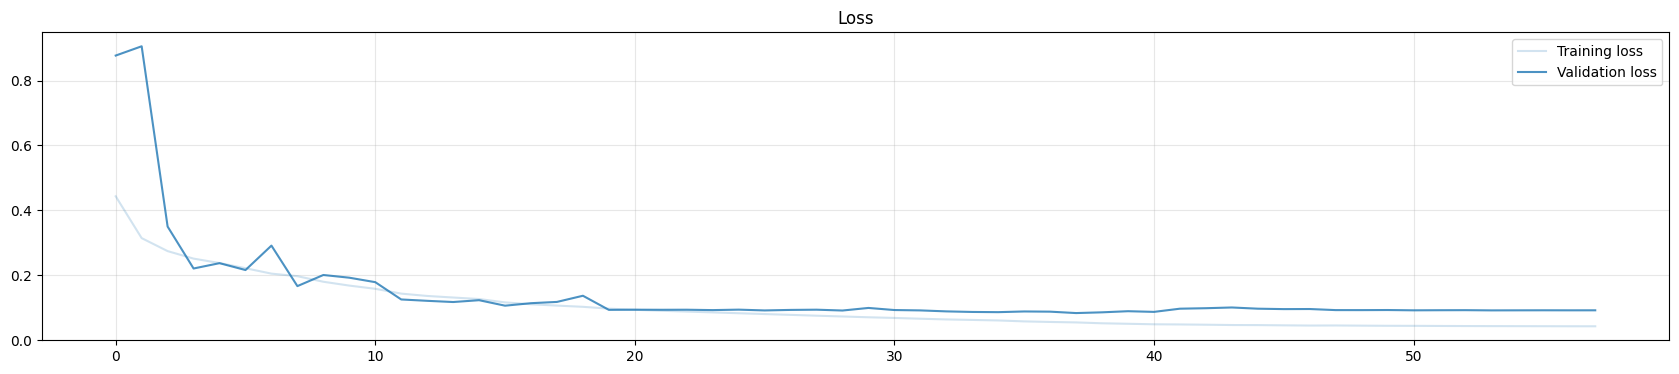

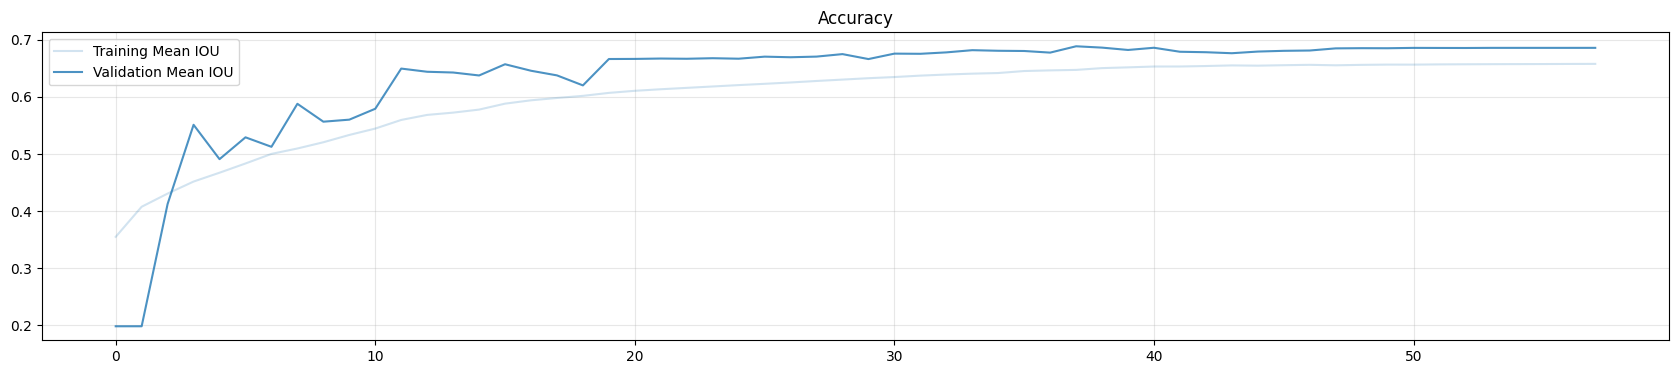

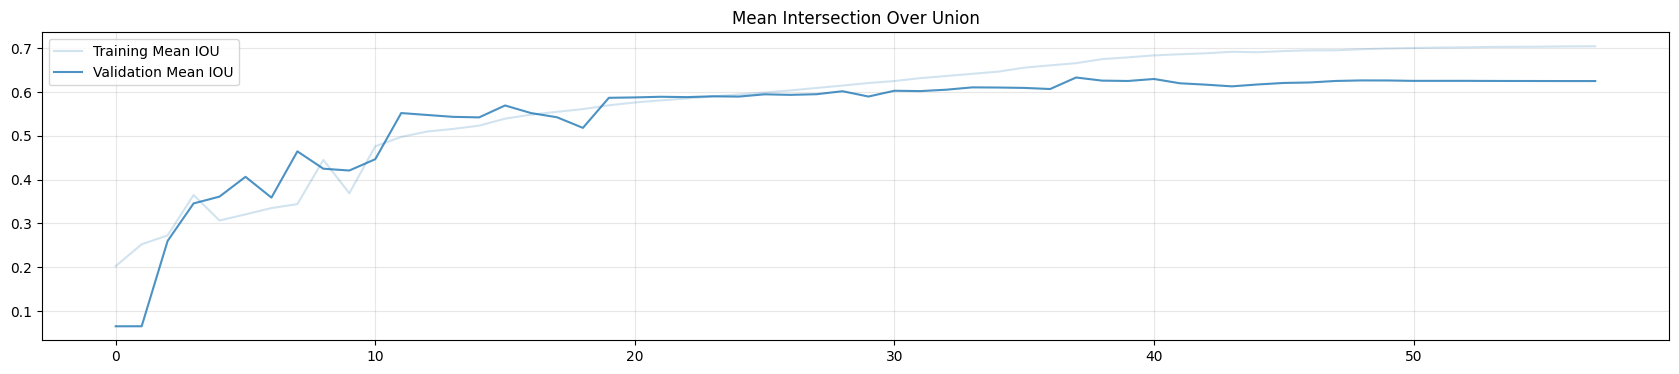

In [ ]:
# Display history
plotTrainingLossAccuracyMeanIOU(history)

# Disconnecting

Disconnect runtime to avoid consuming resources if the notebook has completed its execution.

In [ ]:
goodnight()